# Tarea 2 - Aprendizaje bayesiano

### Grupo 8:
     - Matías González 5199522-2
     - Leonardo Melgar 5206567-4
     - Emiliano Silva 5127389-8


## 1. Objetivo

Este laboratorio tiene por objetivos:

- Implementar el algoritmo Naive Bayes
- Aplicar herramientas de metodología
- Analizar los resultados obtenidos



## 2. Diseño

## 2.1 Preprocesamiento de datos
Primero, procedemos a importar las librerías necesarias para el análisis y procesamiento de datos. Utilizaremos pandas y numpy para la manipulación del dataset, y varios módulos de scikit-learn para la división de datos, evaluación del modelo, selección de atributos y métricas de clasificación. También emplearemos matplotlib y seaborn para la visualización de resultados. Finalmente, importamos las funciones y utilidades implementadas previamente en el archivo lab2.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.estimator_checks import check_estimator
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import PrecisionRecallDisplay
from lab2 import *

Una vez importadas estas utilidades, comenzamos cargando el archivo CSV que contiene los datos que se estáran utilizando para el entrenamiento y testeo de los distintos modelos que serán presentados. Para esto utilizaremos la librería *pandas* que nos permite cargar el dataset a partir de archivos en este formato. Además, al dataset leido, le hemos quitado el atributo *pidnum* ya que este únicamente tiene la utilidad de identificar a cada fila del conjunto de datos, pero no aporta información relevante para el modelo:

In [ ]:
def categorize_numeric_features(df, bins=3):
    """
    Convierte atributos numéricos en categóricos utilizando bins.
    """
    ATTRIBUTES_REQUIRING_RANGES = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
    df_categorized = df.copy()

    for column in ATTRIBUTES_REQUIRING_RANGES:
        df_categorized[column], bins_used = pd.cut(
            df_categorized[column],
            bins=bins,
            labels=False,
            retbins=True
        )

    return df_categorized

# 1. Cargar el dataset y categorizar atributos continuos
dataset = pd.read_csv('./lab1_dataset.csv')
preprocessed_dataset = dataset.drop(['cid', 'pidnum'], axis=1)
target_column = dataset['cid']
preprocessed_dataset = categorize_numeric_features(preprocessed_dataset)

Definimos además como atributo objetivo al atributo *cid*.

Debido a que algunos de los atributos numéricos utilizados van a tener en su valor una variabilidad muy alta (como pueden ser valores continuos o datos como la edad), se “partirán” en rangos los atributos que cumplan con estas características. Para realizar esta categorización, utilizamos la función `pd.cut`, que nos permite dividir los valores numéricos en intervalos discretos. Esto es importante porque más adelante aplicamos Chi-2, una estrategia de selección de atributos que requiere que los atributos sean categóricos para evaluar su relación con la variable objetivo.

Los atributos que corresponde separar en rangos debido a la naturaleza de sus valores son *time, age, wtkg, karnof, preanti, cd40, cd420, cd80* y *cd820*.

## 2.2 Algoritmo

El algoritmo **Naive Bayes** es un clasificador probabilístico basado en la aplicación del teorema de Bayes, bajo la suposición de independencia condicional entre las características dadas la clase. Esta implementación del algoritmo se enfoca en la versión multinomial, que es adecuada para datos categóricos y es comúnmente utilizada en problemas como la clasificación de texto. Hemos enriquecido este modelo con el m-estimador, una técnica que nos ayuda a manejar problemas de sobreajuste y suavizado en las probabilidades condicionales.





### 2.2.1 Entrenamiento (fit)

La función fit entrena el modelo utilizando el conjunto de datos de entrenamiento (dataset_train) y las etiquetas (target_train).



-   #### Identificación de Clases:
Se identifican las clases únicas presentes en el conjunto de datos (0 y 1 en este caso).
Estas clases son almacenadas en self.classes para su uso posterior en las fases de predicción.

-   #### Cálculo de Probabilidades a Priori (P(clase)):
 Calcula la probabilidad a priori de cada clase como la proporción de muestras que pertenecen a esa clase en el conjunto de entrenamiento.
Ejemplo: Si el 60% de las muestras pertenecen a la clase 0 y el 40% a la clase 1, las probabilidades a priori serían
𝑃(0) = 0.6
y 𝑃 (1) = 0.4

- #### Cálculo de Probabilidades Condicionales (P(atributo | clase)):
Para cada clase, la función filtra las muestras de dataset_train que pertenecen a esa clase.

  Se calculan las probabilidades para cada valor de cada atributo dada cierta clase con:

  ### **(e + p*m)/(n + m)**

  e: Conteo de Instancias Favorables. Para cada atributo y cada valor único de ese atributo, cuenta cuántas veces aparece ese valor en las muestras filtradas.

  p: Probabilidad a priori, definida como la inversa del número de valores únicos posibles del atributo.

  n: Número total de instancias en la clase considerada.

  m: Hiperparámetro de suavizado. Controla cuánto se suavizan las probabilidades condicionales para evitar valores nulos.

- #### Almacenamiento de Probabilidades:

  Las probabilidades a priori se almacenan en self.priors y las probabilidades condicionales en self.likelihoods.

  self.likelihoods es un diccionario anidado donde para cada clase y cada atributo se almacena un diccionario de probabilidades para los posibles valores del atributo.









### 2.2.2 Predicción (predict y predict_single)

Se lleva a cabo utilizando las probabilidades a priori y condicionales calculadas durante el entrenamiento.


-   #### Cálculo de la Probabilidad Posterior:

  - Para cada muestra en el conjunto de prueba, se calcula la probabilidad posterior para cada clase. Esto se hace en la función **predict_single**.

  - Inicialización con Probabilidad a Priori:
  Inicia con el logaritmo de la probabilidad a priori de la clase. El uso del logaritmo evita problemas numéricos de underflow cuando se multiplican muchas probabilidades pequeñas.

  - Producto de Probabilidades Condicionales:
  Para cada característica de la muestra, se busca su probabilidad condicional en self.likelihoods.
  Estas probabilidades se multiplican (o se suman sus logaritmos) para calcular la probabilidad conjunta de la muestra bajo la clase dada.

  - Valores No Vistos:
  Si el valor de una característica no fue visto durante el entrenamiento, se le asigna una probabilidad muy baja (1e-9) para evitar problemas de cálculo.
  
-   #### Selección de la Clase con Mayor Probabilidad Posterior:

  Se selecciona la clase con la mayor probabilidad posterior como la clase predicha para la muestra.
  Este proceso se repite para cada muestra en el conjunto de prueba en la función predict.






## 2.3 Evaluación
La evaluación del modelo se debe realizar en un conjunto de datos distinto a aquel sobre el cual se entrenó, con el fin de evitar un sobreajuste. Para esto divideremos el conjunto de datos en un conjunto de entrenamiento y en otro de evaluación.

Es importante observar que las proporciones de las clases objetivo están desbalanceadas:

In [ ]:
class_proportions = target_column.value_counts(normalize=True)
print("Las proporciones de valores de la clase objetivo son:")
print(class_proportions)

Las proporciones de valores de la clase objetivo son:
cid
0    0.756428
1    0.243572
Name: proportion, dtype: float64


Por lo que al momento de separar el conjunto de datos, lo nuevos conjuntos generados para entrenamiento y para evaluacion deben mantener las mismas proporciones, lo cual nos implica que debemos estratificar. Para esto, la librería scikit-learn nos permite indicar que queremos estratificar al momento de hacer la separación de los conjuntos.

In [ ]:
# División del dataset en conjunto de entrenamiento y prueba
dataset_train, dataset_test, target_train, target_test = train_test_split(
	preprocessed_dataset, target_column, test_size=0.2, random_state=42, stratify=target_column
)
dataset_test = dataset_test.to_numpy()

Para evaluar y ajustar los hiperparámetros de nuestro modelo utilizaremos el método de validación cruzada, que consiste en dividir el conjunto de entrenamiento en k partes, utilizando (k-1) partes para entrenar, y la restante para evaluar el modelo, cambiando luego la parte elegida y repitiendo el proceso (al final de todas las iteraciones se devuelve el promedio del valor de performance obtenido). Esto nos garantiza que el modelo se evalúe en diferentes muestras, ayuda a reducir el riesgo de que el modelo se sobreajuste y hace un mejor uso del dataset de entrenamiento. El k seleccionado será de 5, lo cual hace que cada parte elegida para evaluar sea del 20%.

En el caso de la estandarización, creemos que no es necesaria dado que hemos decidido categorizar los atributos continuos, lo que reduce significativamente la variabilidad entre los valores numéricos al agruparlos en intervalos. Al transformar los valores continuos en categorías discretas, nos aseguramos de que los atributos mantengan un aproximadamente el mismo orden, sin la necesidad de técnicas adicionales que busquen corregir desequilibrios o escalas en los datos.

Al momento de la evaluación se tomará como métrica principal la exactitud, la cual nos indica la proporción de predicciones correctas. Además, se considerarán otras métricas importantes como la precisión (proporción de predicciones positivas correctas), la recuperación (proporción de verdaderos positivos identificados por el modelo) y la precisión promedio, que corresponde al área bajo la curva en la gráfica de precisión-recall.


## 3. Experimentación

## 3.1 Selección de atributos

Para la selección de atributos se utilizaron dos métodos:
- Chi-2: Medida aplicada a dos variables categóricas para evaluar si son independientes. Esta medida se utiliza para obtener los atributos más correlacionados con la clase objetivo (y que, por lo tanto, deberían ser mejores predictores).
- Matriz de correlación: Utilizando el método “Pearson”, se rellenó una matriz de correlación con números entre -1 y 1. Cuando dos atributos tienen un valor cercano a 1 o a -1, estos son muy similares, lo cual significa que pueden ser redundantes a la hora de entrenar un modelo.

Ambos métodos fueron aplicados sobre el conjunto de entrenamiento. Además, para que podamos aplicar el método de Chi-2 previamente debimos categorizar los atributos.


### Chi-2



In [ ]:
# Aplicar la técnica de Chi-2 (seleccion de atributos)
chi2_selector = SelectKBest(chi2, k=11)
dataset_train_with_selected_attributes = chi2_selector.fit_transform(dataset_train, target_train)
selected_columns = dataset_train.columns[chi2_selector.get_support()]
print(f"Los atributos seleccionados por chi-2 son: {selected_columns}")

Los atributos seleccionados por chi-2 son: Index(['time', 'trt', 'z30', 'preanti', 'str2', 'strat', 'symptom', 'treat',
       'offtrt', 'cd40', 'cd420'],
      dtype='object')


A la hora de aplicar Chi-2, elegimos los mejores k parámetros según la medida aplicada. A continuación se presenta una tabla con las medidas obtenidas de los diferentes valores de k evaluados:

| Accuracy promedio en validación cruzada | K |
| --- |:---:  |
| 0.849804784069016  | 5 |
| 0.8451264214959167  | 7 |
| 0.8427889451519956  | 8 |
| 0.8427889451519956  | 9 |
| 0.8451264214959167 | 10 |
| 0.8457095118749255  | 11 |
| 0.8410345591870833 | 12 |
| 0.8410328542444546  | 13 |
| 0.8322592194772647  | 15 |
| 0.8322592194772647  | 20 |

*Obs: La accuracy que se tomó para evaluar K con cada valor, es el que se promedia de la validación cruzada.* \
Finalmente, 11 es el valor que mejores resultados dio para el parámetro k, por lo que se decidió mantenerlo.

### Matriz de correlación



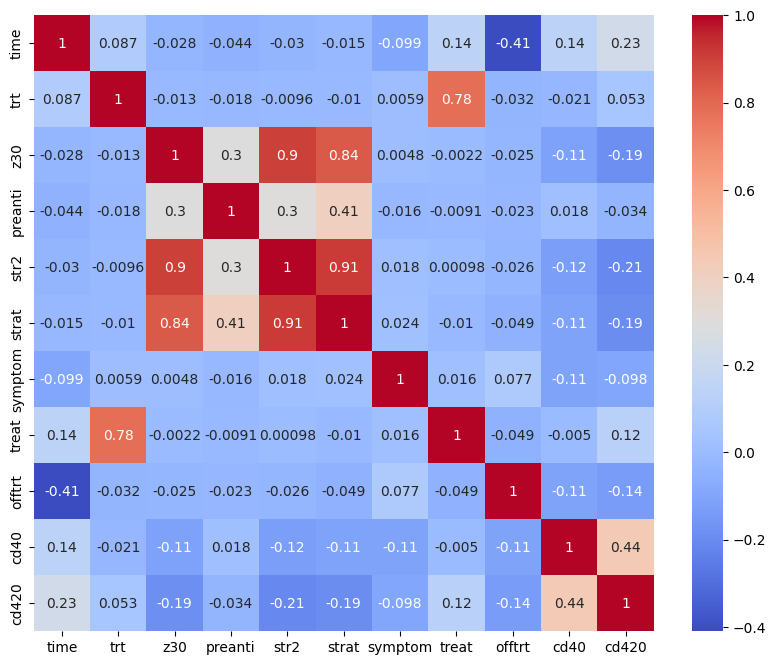

Atributos descartados por alta correlación: ['str2', 'strat']


In [ ]:
# Calcular la matriz de correlación y eliminar atributos con una relacion mayor a 0.85
dataset_train_df = pd.DataFrame(dataset_train_with_selected_attributes, columns=selected_columns)
correlation_matrix = dataset_train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

threshold = 0.85
columns_to_discard = set()
for i in range(len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i, j]) > threshold:
      columns_to_discard.add(correlation_matrix.columns[i])
print(f"Atributos descartados por alta correlación: {list(columns_to_discard)}")

dataset_train = dataset_train_df.drop(columns=columns_to_discard).to_numpy()

Como se puede observar, descartamos uno de los atributos que superan (en valor absoluto) el 0.85 en la matriz de correlación. De esta forma, se destacaron dos atributos (str2 y strat), quedándonos con z30 únicamente.

## 3.2 Matriz de confusión

Vamos a calcular a continuación las matrices de confusión obtenidas a medida que variamos el hiperparámetro m:

Entrenando con m=1


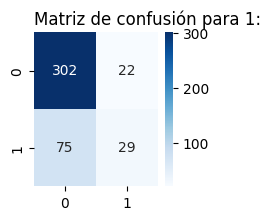

Entrenando con m=10


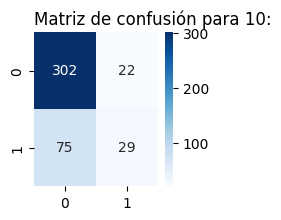

Entrenando con m=100


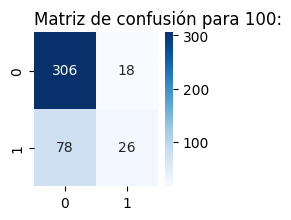

Entrenando con m=1000


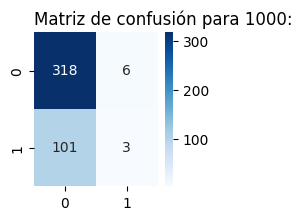

In [ ]:
for m in [1, 10, 100, 1000]:
  target_pred = train_evaluate_naive_bayes(m, dataset_train, target_train, dataset_test)
	# Matriz de confusión
  cm = confusion_matrix(target_test, target_pred)
  plt.figure(figsize=(2, 2))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f")
  plt.title(f"Matriz de confusión con m={m}:")
  plt.show()

Lo primero que notamos es que el modelo suele tener un buen desempeño para la clase 0 donde las cantidades de instancias clasificadas correctamente superan las 300 y las mal clasificadas no superan las 22, lo cual proporcionalmente es bastante bueno (como máximo tenemos solo un 7% de instancias mal clasificadas). Asimismo, notamos que a medida que aumentamos el valor de m, mejora esta proporción aumentando las instancias que se clasifican correctamente y disminuyendo los falsos negativos.

En contraparte, notamos que para la clase 1 el desempeño no es bueno, ya que la cantidad de instancias correctamente clasificadas nunca supera a los falsos negativos. Además de esto, vemos que a medida que aumentamos el valor de m, este desempeño empeora, dando lugar a 101 instancias mal clasificadas y solo 3 correctas. Esto tiene un claro contraste con la clase 0, lo que nos indica que el algoritmo a medida que aumenta m clasifica más instancias en la clase 0, generando así que se clasifiquen de forma incorrecta las instancias de la clase 1, pero que a su vez se acierte con más instancias de la clase 0.

## 3.2 Curva de precision-recall

En ninguno de los diferentes valores de m, la precisión promedio de la curva de precision-recall fue muy cercana a 1. Observemos las obtenidas para los diferentes valores del parámetro m:




Entrenando con m=1


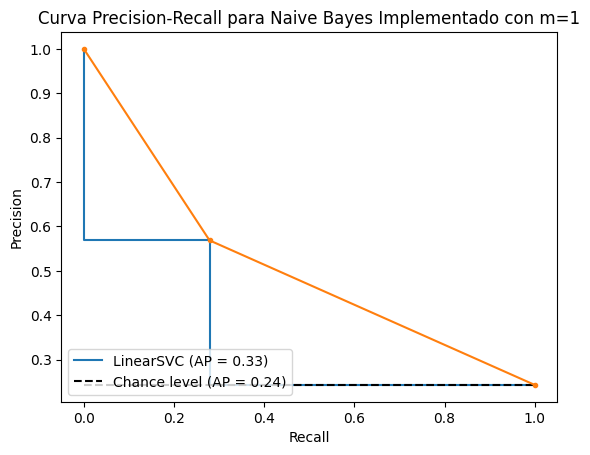

Entrenando con m=10


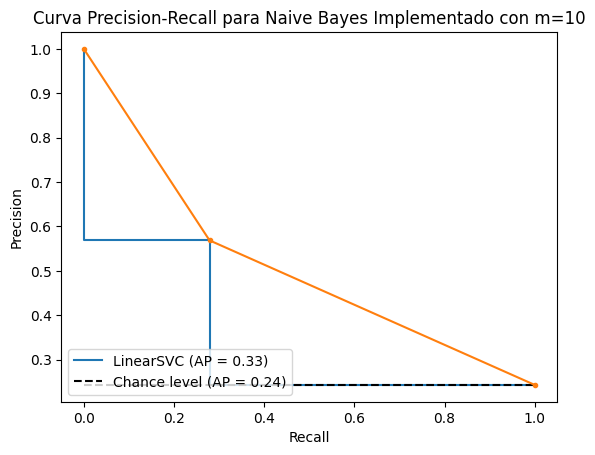

Entrenando con m=100


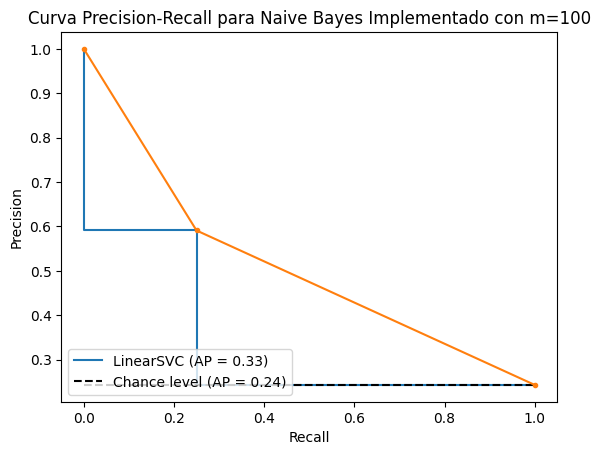

Entrenando con m=1000


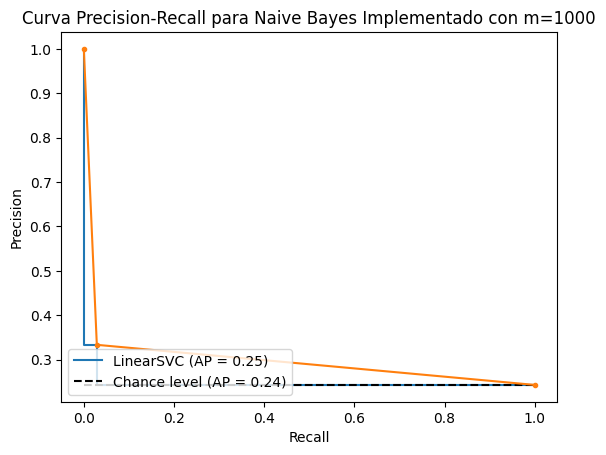

In [ ]:
for m in [1, 10, 100, 1000]:
  target_pred = train_evaluate_naive_bayes(m, dataset_train, target_train, dataset_test)

	# Curva precision-recall
  display = PrecisionRecallDisplay.from_predictions(
    target_test, target_pred, name="LinearSVC", plot_chance_level=True
  )
  precision, recall, _ = precision_recall_curve(target_test, target_pred)

  plt.plot(recall, precision, marker='.')
  plt.title(f"Curva Precision-Recall para Naive Bayes Implementado con m={m}")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.show()


| Parámetro M | Precisión Promedio (AP) |
| --- |:---:  |
| 1 | 0.33 |
| 10 | 0.33 |
| 100  | 0.33 |
| 1000  | 0.25 |

El mejor valor de la precisión promedio se dio en los valores de m = 1, m = 10 y m = 100. En todos los casos la precisión fue mejor que la recuperación, lo que nos puede hacer afirmar que nuestro modelo es más “conservador” ya que predice como negativas muestras que eran positivas (no clasifica tan erróneamente como cuando predice una muestra como positiva).


## 4. Conclusión

## 4.1 Comparación de modelos entre ID3 y Naive Bayes

Veamos la siguiente tabla para comparar las implementaciones de ID3 y Naive Bayes (NB).

|  Modelo   | Exactitud | Presición | Recuperación | Exactitud promedio en validación cruzada |
|-----|----------:|----------:|----:| ----:|
| ID3 |   0.794392523364486    | 0.60 | 0.40| \- |
| NB |   0.775700934579439    | 0.57 |0.28 | 0.8439466011968697 |

A partir de esta tabla tenemos los siguientes comentarios:

- El modelo ID3 obtuvo una mejor exactitud (accuracy) en los datos de prueba con un valor de 0.794, mientras que Naive Bayes alcanzó 0.775. Aunque la diferencia es pequeña, sugiere que ID3 tiene un ligero mejor rendimiento en la clasificación de los datos de prueba.

- En términos de precisión y recall, ID3 también mostró un mejor desempeño, con valores de 0.60 y 0.40, respectivamente, mientras que Naive Bayes alcanzó solo 0.57 y 0.28. Ambos modelos fueron más “conservadores” a la hora de clasificar a una instancia como positiva, lo cual se puede deber a la diferencia de las proporciones de cada clase en el dataset original.

- Si bien Naive Bayes tiene un rendimiento ligeramente inferior en el conjunto de prueba, lo que es notable es que su exactitud promedio en validación cruzada fue bastante buena, alcanzando 0.844. Esto sugiere que Naive Bayes tiene un buen rendimiento general en diferentes particiones del conjunto de datos. Si bien esta medida no se obtuvo para ID3, el valor que se obtuvo para Naive Bayes fue bastante bueno considerando su resultado de exactitud con un único conjunto de prueba.

Si se busca maximizar la exactitud en un conjunto de prueba específico, ID3 parece ser una mejor opción. Sin embargo, si se prefiere un modelo con un comportamiento estable en diferentes particiones de los datos, Naive Bayes podría ser una buena opción debido a sus resultados en la exactitud promedio obtenido de la validación cruzada (igualmente se debe tener en cuenta que esta medida no fue obtenida para el algoritmo implementado para ID3).


### Relacionado con el Algoritmo


Concluimos que el m-estimador suaviza las probabilidades condicionales de valores observados para evitar problemas de sobreajuste, sin embargo no puede prever ni asignar probabilidades a valores no presentes en el entrenamiento. Para valores nuevos se necesita un manejo explícito durante la fase de predicción asignando una probabilidad muy baja (1e-9).